<a href="https://colab.research.google.com/github/usman-pasha-786/assignment-PIAIC/blob/main/project_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
from google.colab import userdata
LANGSMITH_API_KEY = userdata.get('LANGCHAIN_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain.tools import Tool
from langgraph.graph import END
from langgraph.graph import MessagesState

def process_property_message(message: str) -> str:
    """Respond to property-related messages based on detected keywords.

    Args:
        message: The user's input message.

    Returns:
        A response if the message is property-related, otherwise a default message.
    """
    keywords_responses = {
        "rent": "When renting, ensure you understand the lease terms and check the property's condition.",
        "lease": "When renting, ensure you understand the lease terms and check the property's condition.",
        "buying": "Buying property? Focus on location, market trends, and securing good financing options.",
        "investment": "Investing in property requires assessing market conditions, location, and potential ROI.",
        "selling": "To sell property successfully, ensure it’s well-maintained and priced competitively.",
        "mortgage": "Compare mortgage rates, terms, and fees from multiple lenders before deciding.",
    }

    message_lower = message.lower()
    for keyword, response in keywords_responses.items():
        if keyword in message_lower:
            return response

    return "Sorry, I only answer property-related questions. Feel free to ask!"

# function for handle the rent property
def handle_rent_sale_query(message: str) -> str:
    """Respond to rent or sale-related queries with expert dealer contact details.

    Args:
        message: The user's input message.

    Returns:
        A contact response if the message is about renting or selling, otherwise a default response.
    """
    rent_keywords = ["rent", "rental", "leasing", "lease"]
    sale_keywords = ["sale", "selling", "buy", "purchase"]

    message_lower = message.lower()

    if any(keyword in message_lower for keyword in rent_keywords):
        return (
            "For rental property assistance, please contact our expert dealer:\n"
            "Name: Mr. sajid awan\n"
            "Phone: +1-234-567-8901\n"
            "Email: Sajid.awan.doe@propertyexpert.com\n"
            "Feel free to reach out for personalized support!"
        )
    elif any(keyword in message_lower for keyword in sale_keywords):
        return (
            "For property sales or purchase assistance, please contact our expert dealer:\n"
            "Name: Ms. Usman\n"
            "Phone: +1-987-654-3210\n"
            "Email: usman@propertyexpert.com\n"
            "Feel free to reach out for personalized support!"
        )

    return "I can provide expert contact details for rent or sale-related queries. Please ask about renting or selling a property."


# Defining the tool
tools = [process_property_message,handle_rent_sale_query]
#     name="property Assistant",
#     func=process_property_message,
#     description="Responds to property-related queries including rent properties and sale properties"
# )

# Initialize the LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)

# Bind tools with LLM
llm_with_tools = llm.bind_tools(tools)


In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(
    content="""
    Welcome to the Property Assistance System!
    I can help with property-related topics like:

    Renting or leasing
    Buying or selling property
    Mortgages and investments
    Renovation and construction
    Tenant or landlord responsibilities
    Just type your question, and I’ll provide a helpful response!

    If your question isn’t property-related, I’ll kindly let you know. 😊
    """
)

# Node
def assistant(state: MessagesState) -> MessagesState:
    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]
    }


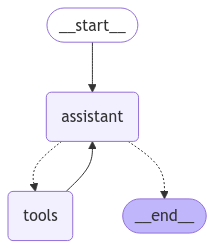

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes:
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: \
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",

    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# for display
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
llm_with_tools.invoke("want to buy property")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'process_property_message', 'arguments': '{"message": "want to buy property"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0bd487d4-c20d-4f0c-8db1-96dccdd94e52-0', tool_calls=[{'name': 'process_property_message', 'args': {'message': 'want to buy property'}, 'id': '883cc1a1-ddc3-4aea-ab1f-327c521bf927', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 10, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}})

In [ ]:
# Create a thread
#  using stream mode
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in react_graph.stream({"messages": [HumanMessage(content="hi")]}, config, stream_mode="updates"):
    print(chunk)

{'assistant': {'messages': [AIMessage(content='Hello! How can I help you with your property needs today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8a8aa2dc-d9c3-44ea-9918-b22a66bb9ecc-0', usage_metadata={'input_tokens': 144, 'output_tokens': 14, 'total_tokens': 158, 'input_token_details': {'cache_read': 0}})]}}


In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [ ]:
#  without stream mode
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="do you help me in property buy in karachi?")]

messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

who is best fitness idea
================================== Ai Message ==================================

That's not a property-related question, so I can't help with that.  I'm designed to assist with questions about renting, buying, selling, mortgages, renovations, and tenant/landlord responsibilities.
================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello! How can I help you with your property questions today?
================================ Human Message =================================

do you help me in property buy in karachi?
================================== Ai Message ==================================

I cannot directly help you buy property in Karachi. I am a language model and do not have access to real-time information, such as property listings, market prices, or legal p

In [ ]:
from google.colab import drive
drive.mount('/content/drive')